In [ ]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#imports
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from PIL import Image
import os
from torch.utils.data import Subset, SubsetRandomSampler

In [ ]:
class AE(nn.Module):
  def __init__(self):
    super().__init__()
    #encode
    #input is 3 x 32 x 32
    self.layer1 = nn.Sequential(
        nn.Conv2d(3,64,3, padding=1),  #64 x 32 x 32
        nn.ReLU(),
        nn.MaxPool2d(2,2) #64 x 16 x 16
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(64,32,3, padding=1), #32 x 16 x 16 
        nn.ReLU(),
        nn.MaxPool2d(2,2) #32 x 8 x 8
    )
    self.layer3 = nn.Sequential(
        nn.Conv2d(32,16,3, padding=1),  #16 x 8 x 8
        nn.ReLU(),
        nn.Conv2d(16,16,3, padding=1), #16 x 8 x 8
        nn.ReLU()
    )
    #decode
    self.layer4 = nn.Sequential(
        nn.Conv2d(16,16,3, padding=1), #16 x 8 x 8
        nn.ReLU()
    )
    self.layer5 = nn.Sequential(
        nn.Conv2d(16,16,3, padding=1),  #16 x 8 x 8
        nn.ReLU(),
        nn.Upsample(scale_factor=2) #16 x 16 x 16
    )
    self.layer6 = nn.Sequential(
        nn.Conv2d(16,16,3, padding=1), #16 x 16 x 16
        nn.ReLU(),
        nn.Upsample(scale_factor=2),  #16 x 32 x 32
        nn.Conv2d(16,3,3, padding=1) #3 x 32 x 32
    )

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.layer5(out)
    out = self.layer6(out)

    return out

  #to extract latent layers later
  def extract_latent(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)

    return out

  def extract_all(self, x):
    res = []
    out = self.layer1(x)
    res.append(out)
    out = self.layer2(out)
    res.append(out)
    out = self.layer3(out)
    res.append(out)
    out = self.layer4(out)
    res.append(out)
    out = self.layer5(out)
    res.append(out)
    
    return res


In [ ]:
def mse_threshold_separation_calc(mses, separator, increment=0.001):
  #ideal separation: if we considered the true sets of inliers and outliers
  c = list( zip( mses[:separator], ["i" for x in range(separator)] ) )
  o = list( zip( mses[separator:], ["o" for x in range(len(mses) - separator)] ) )
  #add labels to everything to track these
  c_avg = sum(mses[:separator]) / separator
  c_var = sum((x-c_avg)**2 for x in mses[:separator]) / separator
  o_avg = sum(mses[separator:]) / len(mses[separator:])
  o_var = sum((x-o_avg)**2 for x in mses[separator:]) / len(mses[separator:])

  ideal_separation = (c_avg - o_avg)**2 / (c_var + o_var)

  #separatation after applying a threshold

  #check these threshold values
  thresholds = np.arange(0, max(mses[separator:]), increment)
  n_out_rejected = 0
  n_in_rejected = 0
  inliers, outliers = [], []

  #get inliers, outliers for each threshold value considered
  for threshold in thresholds:
    inl = []
    in_ind = []
    outl = []
    out_ind = []

    for i in range(len(mses)):
      if mses[i] > threshold:
        outl.append(mses[i])
        out_ind.append(i)
        if i < separator:
          n_in_rejected += 1
        else:
          n_out_rejected += 1
      else:
        inl.append(mses[i])
        in_ind.append(i)

    inliers.append( list( zip( inl, in_ind ) ) )
    outliers.append( list( zip( outl, out_ind ) ) )

  separations = []
  in_hit_rates = []
  out_hit_rates = []
  for t in range(len(thresholds)):

    ins = [i for i,j in inliers[t]]
    outs = [i for i,j in outliers[t]]

    #calc separations of each distribution for each threshold
    in_avg = sum(ins) / (len(ins) if len(ins) != 0 else 1)
    in_var = sum((x-in_avg)**2 for x in ins) / (len(ins) if len(ins) != 0 else 1)
    ot_avg = sum(outs) / (len(outs) if len(outs) != 0 else 1)
    ot_var = sum((x-ot_avg)**2 for x in outs) / (len(outs) if len(outs) != 0 else 1)
    separation = (in_avg - ot_avg)**2 / (in_var + ot_var)
    separations.append(separation)

    #get inlier % outlier % hit rate
    #rate at whch inliers,outliers are correctly identified
    in_hit_rate = 0
    out_hit_rate = 0

    for i in inliers[t]:
      if i[1] < separator:
        in_hit_rate += 1
    
    for o in outliers[t]:
      if o[1] >= separator:
        out_hit_rate += 1

    p = out_hit_rate
    in_hit_rate /= separator
    out_hit_rate /= len(mses[separator:])
    #if(t < 1000):
     # print(p,out_hit_rate,'-'*20)

    in_hit_rates.append(in_hit_rate)
    out_hit_rates.append(out_hit_rate)

  return (thresholds, in_hit_rates, out_hit_rates, mses, separator)

#MSE Eval Function
def MSE_EVAL(model, criterion, targetDataLoader, otherDataLoader):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  mses = []
  for images, labels in targetDataLoader:
    if(device.type == "cuda"):
      images = images.cuda()
    out = model(images)
    loss = criterion(out, images)
    mses.append(loss.item())
  
  separator = len(mses)

  for images, labels in otherDataLoader:
    if(device.type == "cuda"):
      images = images.cuda()
    out = model(images)
    loss = criterion(out, images)
    mses.append(loss.item())

  eval_data = mse_threshold_separation_calc(mses, separator, increment=0.001)
  return eval_data
  


In [ ]:
'''
Performs training and testing using eval_fn for autoencoder model
Returns 
figures{
  train_losses: [],
  example_image: ,
  example_reconstruction: ,

},
eval_data --> returned from eval_fn

'''

#run given model with given transform (preprocessing), get results
#eval_fn(model, targetDataLoader, otherDataLoader)
def anomaly_trial(modelClass, transform, target_class, eval_fn, n_epochs=20):
  target_indeces = []
  other_class_indeces = []

  #load and index train data by class
  cifar = datasets.CIFAR10('.', train=True, download=True, transform=transform)
  target_idx = cifar.class_to_idx[target_class]

  for i in range(len(cifar)):
    current_class = cifar[i][1]
    if current_class == target_idx:
      target_indeces.append(i)
    else:
      other_class_indeces.append(i)

  trainloader = torch.utils.data.DataLoader(cifar, batch_size=100, shuffle=False, sampler=SubsetRandomSampler(target_indeces))

  #store figures for later
  figures = {}

  #train model
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  if(device.type == "cuda"):
    print("Training on GPU")
  else:
    print("Training on CPU")

  model = modelClass().to(device)
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  '''
  num_epochs = 5
  num_classes = 10
  batch_size = 100
  learning_rate = 0.001
  '''
  num_epochs = n_epochs

  losses = []
  i = 0
  for epoch in range(num_epochs):
    i+=1
    for images, labels in trainloader:
      if(device.type == "cuda"):  #convert from torch.floattensor to torch.cuda.floattensor
        images = images.cuda()
      out = model(images)
      loss = criterion(out, images) #loss based on similarity to input
      losses.append(loss.item())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      print('Epoch {}/{}, Loss: {:.6f}'.format(i, num_epochs, loss.item()))

  figures['train_losses'] = losses

  d = enumerate(trainloader)
  idx, (img, label) = next(d)
  figures ['example_image'] = img[80].permute((1,2,0))
  figures['example_reconstruction'] = model(img.cuda())[80].permute(1,2,0).cpu().detach().numpy()

  #load and index test data
  cifar_test = datasets.CIFAR10('.', train=False, download=True, transform=transform)
  target_test_idx = cifar_test.class_to_idx[target_class]

  target_test_indeces = []
  other_class_test_indeces = []

  for i in range(len(cifar_test)):
    current_class = cifar_test[i][1]
    if current_class == target_test_idx:
      target_test_indeces.append(i)
    else:
      other_class_test_indeces.append(i)

  target_testloader = torch.utils.data.DataLoader(cifar_test, batch_size=100, shuffle=False, sampler=SubsetRandomSampler(target_test_indeces))
  other_class_testloader = torch.utils.data.DataLoader(cifar_test, batch_size=100, shuffle=False, sampler=SubsetRandomSampler(other_class_test_indeces))

  eval_data = eval_fn(model, criterion, target_testloader, other_class_testloader)

  return figures, eval_data




  

In [ ]:
transform = transforms.Compose([    
  transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
  ])

figures, eval_data = anomaly_trial(AE, transform, 'cat', MSE_EVAL)

Extracting ./cifar-10-python.tar.gz to .
Training on GPU
Epoch 1/20, Loss: 0.290306
Epoch 1/20, Loss: 0.283208
Epoch 1/20, Loss: 0.293200
Epoch 1/20, Loss: 0.287574
Epoch 1/20, Loss: 0.291569
Epoch 1/20, Loss: 0.293595
Epoch 1/20, Loss: 0.270495
Epoch 1/20, Loss: 0.268902
Epoch 1/20, Loss: 0.272727
Epoch 1/20, Loss: 0.248163
Epoch 1/20, Loss: 0.224766
Epoch 1/20, Loss: 0.214537
Epoch 1/20, Loss: 0.196052
Epoch 1/20, Loss: 0.166917
Epoch 1/20, Loss: 0.188791
Epoch 1/20, Loss: 0.202186
Epoch 1/20, Loss: 0.160819
Epoch 1/20, Loss: 0.148968
Epoch 1/20, Loss: 0.147785
Epoch 1/20, Loss: 0.158522
Epoch 1/20, Loss: 0.156439
Epoch 1/20, Loss: 0.154336
Epoch 1/20, Loss: 0.151555
Epoch 1/20, Loss: 0.144478
Epoch 1/20, Loss: 0.131673
Epoch 1/20, Loss: 0.140669
Epoch 1/20, Loss: 0.132086
Epoch 1/20, Loss: 0.126437
Epoch 1/20, Loss: 0.117155
Epoch 1/20, Loss: 0.122226
Epoch 1/20, Loss: 0.113226
Epoch 1/20, Loss: 0.120752
Epoch 1/20, Loss: 0.134251
Epoch 1/20, Loss: 0.121310
Epoch 1/20, Loss: 0.11794

In [ ]:
def plot_figures(figures):
  plt.figure()
  plt.title('train_losses')
  losses = figures['train_losses']
  plt.plot(range(len(losses)), losses)

  plt.figure()
  plt.title('example_image')
  plt.imshow(figures['example_image'], cmap='Greys')

  plt.figure()
  plt.title('example_reconstruction')
  plt.imshow(figures['example_reconstruction'], cmap='Greys')

def plot_MSE_trial(eval_data):
  (thresholds, in_hit_rates, out_hit_rates, mses, separator) = eval_data
  #histogram of mses, inlier vs outlier
  plt.figure()
  plt.title('MSEs of Inliers(Blue) vs Outliers(Orange)')
  plt.hist(mses[:separator], fc=(0,0,1,0.5))
  plt.hist(mses[separator:], fc=(1,0,0,0.5))

  #plot inlier/outlier hit rates for thresholds
  plt.figure()
  plt.title('Thresholds vs Inlier and Outlier Classification Rates')
  plt.plot(thresholds, in_hit_rates, label='% Inliers Correctly Classified ', color='blue')
  plt.plot(thresholds, out_hit_rates, label='% Outliers Correctly Classified', color='red')
  plt.xlabel('Threshold on MSE')
  plt.xlim(0,0.04)
  plt.legend()
  plt.show()


**In order:**


1.   Training Loss
2.   Cat Image
3.   Reconstructed Cat Image
4.   MSEs for inliers vs outliers
5.   Inlier/Outlier Classification Rate wrt threshold applied on MSE Histogram



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


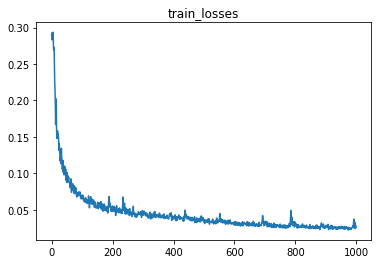

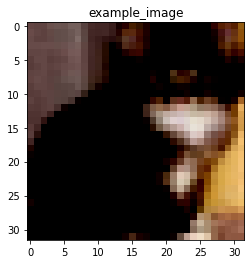

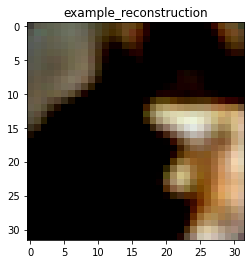

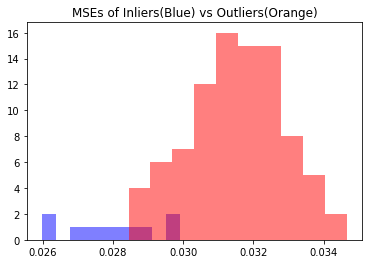

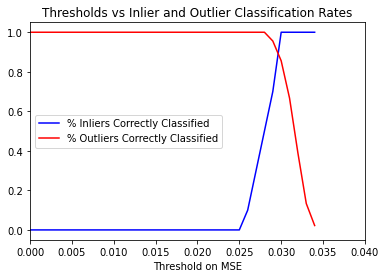

In [ ]:
plot_figures(figures)
plot_MSE_trial(eval_data)

In [ ]:
#this calculates precision or recall if you pass FP or FN as the second parameter
def precision(tp, fp):
  return tp / (tp + fp)

def posneg_thresh(mses, separator, thresholds):
  #get tp,fp,tn,fn for each threshold value considered
  tps = []
  fps = []
  tns = []
  fns = []

  for threshold in thresholds:
    tp = 0
    fp = 0
    fn = 0
    tn = 0

    for i in range(len(mses)):
      if mses[i] > threshold:
        if i < separator:
          fp += 1
        else:
          tp += 1
      else:
        if i >= separator:
          fn += 1
        else:
          tn += 1

    tps.append(tp)
    fps.append(fp)
    tns.append(tn)
    fns.append(fn)

  return (tps, fps, tns, fns)

def mse_f1_calc(mses, separator, increment=0.001):
  #check these threshold values
  thresholds = np.arange(0, max(mses[separator:]), increment)

  (tps, fps, tns, fns) = posneg_thresh(mses, separator, thresholds)
  f1s = []

  for i in range(len(tps)):
    f1 = tps[i] / (tps[i] + 0.5*(fps[i] + fns[i]))
    f1s.append(f1)

  return (f1s, thresholds, mses, separator)

def plot_mse_hist(mses, separator):
  #histogram of mses, inlier vs outlier
  plt.figure()
  plt.title('MSEs of Inliers(Blue) vs Outliers(Orange)')
  plt.hist(mses[:separator], fc=(0,0,1,0.5))
  plt.hist(mses[separator:], fc=(1,0,0,0.5))

def plot_f1_mse_trial(eval_data):
  (f1s, thresholds, mses, separator) = eval_data

  plot_mse_hist(mses, separator)

  plt.figure()
  plt.title('F1 Score vs Threshold Applied')
  plt.plot(thresholds, f1s, color='green')
  plt.xlabel('Threshold on MSE')
  plt.ylabel('F1 Score')
  plt.show()

def F1_MSE_EVAL(model, criterion, targetDataLoader, otherDataLoader):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  mses = []
  for images, labels in targetDataLoader:
    if(device.type == "cuda"):
      images = images.cuda()
    out = model(images)
    loss = criterion(out, images)
    mses.append(loss.item())
  
  separator = len(mses)

  for images, labels in otherDataLoader:
    if(device.type == "cuda"):
      images = images.cuda()
    out = model(images)
    loss = criterion(out, images)
    mses.append(loss.item())

  eval_data = mse_f1_calc(mses, separator, increment=0.001)

  return eval_data

In [ ]:
transform = transforms.Compose([    
  transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
  ])

figures, eval_data = anomaly_trial(AE, transform, 'cat', F1_MSE_EVAL)

**In order:**


1.   Training Loss
2.   Cat Image
3.   Reconstructed Cat Image
4.   MSEs for inliers vs outliers
5.   F1 Score wrt threshold applied on MSE Histogram



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


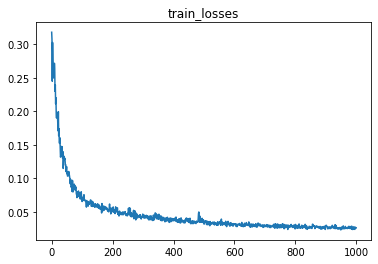

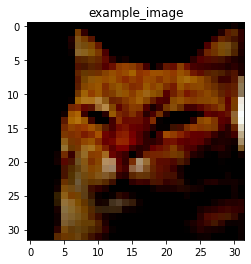

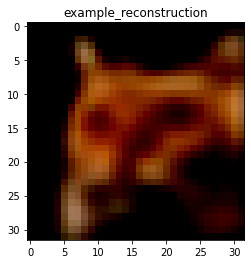

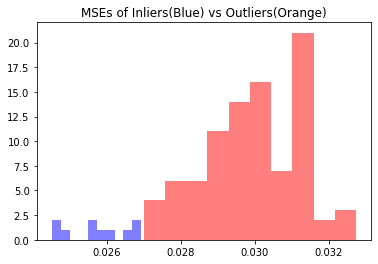

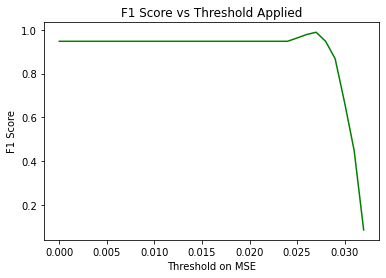

In [ ]:
plot_figures(figures)
plot_f1_mse_trial(eval_data)

In [ ]:
from sklearn.metrics import auc

def pr_curve_calc_mse(mses, separator, increment=0.001):
  #check these threshold values
  thresholds = np.arange(0, max(mses[separator:]), increment)

  (tps, fps, tns, fns) = posneg_thresh(mses, separator, thresholds)

  precisions = []
  recalls = []

  for i in range(len(tps)):
    precisions.append(precision(tps[i],fps[i]))
    recalls.append(precision(tps[i],fns[i]))
    
  area_under_curve = auc(recalls,precisions)

  return (precisions, recalls, area_under_curve, mses, separator, thresholds)

def plot_PR_EVAL_MSE(eval_data):
  (precisions, recalls, area_under_curve, mses, separator, thresholds) = eval_data

  plot_mse_hist(mses, separator)

  plt.figure()
  plt.title('Precision vs Recall Curve')
  plt.plot(recalls, precisions)
  plt.xlabel('Recall at various thresholds')
  plt.ylabel('Precision at various thresholds')
  
  plt.show()

  print("AUC: " + str(area_under_curve))


def PR_EVAL_MSE(model, criterion, targetDataLoader, otherDataLoader):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  mses = []
  for images, labels in targetDataLoader:
    if(device.type == "cuda"):
      images = images.cuda()
    out = model(images)
    loss = criterion(out, images)
    mses.append(loss.item())
  
  separator = len(mses)

  for images, labels in otherDataLoader:
    if(device.type == "cuda"):
      images = images.cuda()
    out = model(images)
    loss = criterion(out, images)
    mses.append(loss.item())

  eval_data = pr_curve_calc_mse(mses, separator, increment=0.001)

  return eval_data

In [ ]:
transform = transforms.Compose([    
  transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
  ])

figures, eval_data = anomaly_trial(AE, transform, 'cat', PR_EVAL_MSE)

Files already downloaded and verified
Training on GPU
Epoch 1/20, Loss: 0.282276
Epoch 1/20, Loss: 0.269222
Epoch 1/20, Loss: 0.270513
Epoch 1/20, Loss: 0.271783
Epoch 1/20, Loss: 0.264851
Epoch 1/20, Loss: 0.242185
Epoch 1/20, Loss: 0.274225
Epoch 1/20, Loss: 0.253989
Epoch 1/20, Loss: 0.262293
Epoch 1/20, Loss: 0.256585
Epoch 1/20, Loss: 0.234913
Epoch 1/20, Loss: 0.228174
Epoch 1/20, Loss: 0.193305
Epoch 1/20, Loss: 0.205156
Epoch 1/20, Loss: 0.202232
Epoch 1/20, Loss: 0.169330
Epoch 1/20, Loss: 0.175479
Epoch 1/20, Loss: 0.175942
Epoch 1/20, Loss: 0.171854
Epoch 1/20, Loss: 0.152056
Epoch 1/20, Loss: 0.155182
Epoch 1/20, Loss: 0.158423
Epoch 1/20, Loss: 0.162420
Epoch 1/20, Loss: 0.157982
Epoch 1/20, Loss: 0.148517
Epoch 1/20, Loss: 0.136861
Epoch 1/20, Loss: 0.135386
Epoch 1/20, Loss: 0.135278
Epoch 1/20, Loss: 0.140819
Epoch 1/20, Loss: 0.125391
Epoch 1/20, Loss: 0.122023
Epoch 1/20, Loss: 0.127125
Epoch 1/20, Loss: 0.128584
Epoch 1/20, Loss: 0.120055
Epoch 1/20, Loss: 0.116855
E

**In order:**


1.   Training Loss
2.   Cat Image
3.   Reconstructed Cat Image
4.   MSEs for inliers vs outliers
5.   Precision Recall Curve wrt threshold applied on MSE Histogram



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


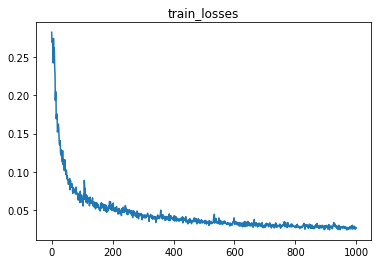

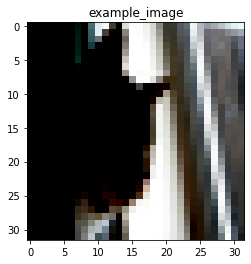

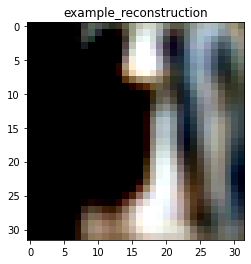

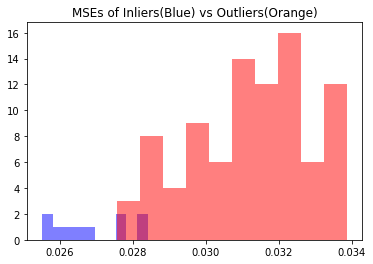

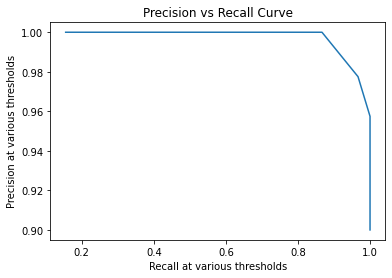

AUC: 0.8422370972454645


In [ ]:
plot_figures(figures)
plot_PR_EVAL_MSE(eval_data)